# Machine Learning NLP Capstone Project

## Toxic Comment Classification

In [1]:
#changing working directory
import os
os.chdir("C:\\Users\\sweth\\Google Drive\\Data Science\\SpringBoard\\NLP")
os.getcwd()

'C:\\Users\\sweth\\Google Drive\\Data Science\\SpringBoard\\NLP'

### Import basic machine learning packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib inline
import seaborn as sns
import itertools

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
#from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
from sklearn.externals import joblib

C:\Users\sweth\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### load datasets

In [4]:
toxic_train = pd.read_csv('train.csv')
toxic_test = pd.read_csv('test.csv')
toxic_test_label = pd.read_csv('test_labels.csv')

The problem is a multi label problem:

#### What is a multilabel problem?

A multilabel problem is a classificatoin problem in which the input can be mapped into different classes. This can be better considered with the movie genres. We would have seen many labels for the movies in theatres. A single movie will be classified as 'Romance", "Comedy" genres at the same time.

#### How to Solve the Problem? We can approach this in 3 ways:

#one v/s All
#one v/s one
#Error Correcting Output Codes

#### One v/s All

This strategy, also known as one-vs-all, is implemented in OneVsRestClassifier. The strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes. Advantage of this approach is its interpretability. Since each class is represented by one and only one classifier, it is possible to gain knowledge about the class by inspecting its corresponding classifier. This is the most commonly used strategy and is a fair default choice. So we shall go by this method

### Embeddings

LIke any other machine learning algorithms these classifiers cannot work on the texts. so we need to find a way to convert thetexts into numerical equivalents We have two ways to do that :

TFIDF
Word2Vec
I think these two terminologies are much familar to every1. hence we can see a way to implement them

## Natural Language Processing

### importing NLP Packages

In [5]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
nltk.download('wordnet')
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import string

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sweth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sweth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sweth\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Cleaning and Preprocessing

In [6]:
#convert string to lower case
toxic_train['comment_text']= toxic_train['comment_text'].str.lower()

In [7]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

In [8]:
def remove_punctuation(text):
    no_punct="".join([c for c in text if c not in string.punctuation])
    return no_punct

In [9]:
toxic_train['clean'] = toxic_train['comment_text'].apply(lambda x: remove_special_characters(x))
toxic_train['clean'] = toxic_train['clean'].str.split("\n")
toxic_train['clean'] = toxic_train['clean'].apply(lambda x: remove_punctuation(x))

### Instantiate Tokenizer

#### This breaks up the strings into a list of words or pieces

In [10]:
toxic_train['tokenized_words'] = toxic_train.apply(lambda row: nltk.word_tokenize(row['clean']), axis=1)

### Lemmatizing

####  Lemmatizing shortens words back to their root form. It maps common words into one base. Unlike stemming though, it always returns a proper word that can be found in the dictionary. It is an organized & step by step procedure of obtaining the root form of the word, it makes use of vocabulary (dictionary importance of words) and morphological analysis (word structure and grammar relations).

In [11]:
#instantiate lemmatizer
lemmatizer = WordNetLemmatizer()
def word_lemmatizer(text):
    lem_text = [lemmatizer.lemmatize(i) for i in text]
    return lem_text

In [12]:
toxic_train['lemma'] = toxic_train['tokenized_words'].apply(lambda x: word_lemmatizer(x))

### Remove Stopwords

#### We imported a list of the most frequently used words from the NL Toolkit at the beginning with from nltk.corpus import stopwords. You can run stopwords.word(insert language) to get a full list for every language. There are 179 English words, including ‘i’, ‘me’, ‘my’, ‘myself’, ‘we’, ‘you’, ‘he’, ‘his’, for example. We usually want to remove these because they have low predictive power. There are occasions when you may want to keep them though. Such as, if your corpus is very small and removing stop words would decrease the total number of words by a large percent.


In [13]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

In [93]:
toxic_train['no_stp-wrds'] = toxic_train['lemma'].apply(lambda x: remove_stopwords(x))

### Words_Length Distribution

In [19]:
toxic_train['no_stp_len']=toxic_train['no_stp-wrds'].apply(lambda x: len(x))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025A09317898>]],
      dtype=object)

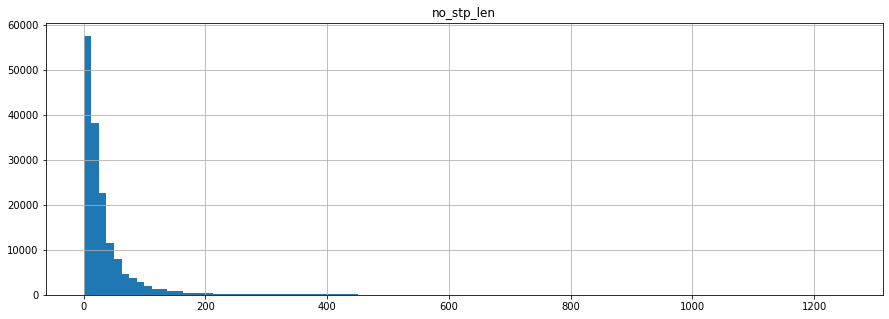

In [20]:
#most of the sentences have upto 100 words, with some outliers of 400 words in a sentence
toxic_train.hist(column='no_stp_len',bins=100,figsize=(15, 5))
#df['TransactionAmt'].apply(np.log).plot(kind='hist',bins=100,figsize=(15, 5), title='Distribution of Log Transaction Amt')

### Number of comments in each category

In [23]:
df_toxic = toxic_train.drop(['id', 'comment_text','clean','lemma','tokenized_words','no_stp-wrds',
                            'no_stp_len','wrds_join'], axis=1)
counts = []
categories = list(df_toxic.columns.values)
for i in categories:
    counts.append((i, df_toxic[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,toxic,15294
1,severe_toxic,1595
2,obscene,8449
3,threat,478
4,insult,7877
5,identity_hate,1405


### Number of comments per category

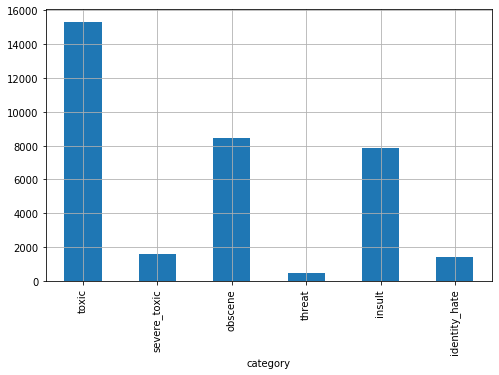

In [25]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
#plt.title("Number of comments per category")
#plt.ylabel('# of Occurrences', fontsize=12)
#plt.xlabel('category', fontsize=12)

### Joining Lemmatization list back to string

In [21]:
def join(text):
    str_join=" ".join([c for c in text])
    return str_join

In [22]:
toxic_train['wrds_join'] = toxic_train['no_stp-wrds'].apply(lambda x: join(x))

In [18]:
### Save Processed Data
toxic_train.to_csv('lemma.csv', index=False)

In [19]:
clean_data = pd.read_csv('lemma.csv')

### Word counts with bag of words

#### Converts text into matrix where every row is an observation and every feature is a unique word. The value of each element in the matrix is either binary indicator marking the presence of that word or an integer of the number of times a word appears

In [26]:
# Creating the Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 1500)
X = cv.fit_transform(toxic_train['wrds_join']).toarray()

In [27]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [35]:
!pip install collections-extended

In [28]:
import collections
from collections import Counter

In [48]:
#Bigrams
counts = collections.Counter()
for sent in toxic_train["wrds_join"]:
    words = nltk.word_tokenize(sent)
    #counts.update(nltk.bigrams(words))
    counts.update(words)

In [51]:
#most frequently occuring words
counts.most_common(10)

[('article', 70825),
 ('wa', 54426),
 ('page', 54102),
 ('wikipedia', 33796),
 ('talk', 31434),
 ('ha', 31173),
 ('one', 29532),
 ('would', 29092),
 ('like', 27994),
 ('please', 27791)]

### Gensim

In [24]:
# Importing Gensim
import gensim
from gensim import corpora
from gensim.corpora.dictionary import Dictionary

### Word2Vec

### Model 1: Word2Vec with OneV/s All

#Each word is represented as a vector of 32 more dimension instead of single number
#Semantic Information and relation between different words is also preserved
#Word2vec, like doc2vec, belongs to the text preprocessing phase. 
#Specifically, to the part that transforms a text into a row of numbers. 
#Word2vec is a type of mapping that allows words with similar meaning to have similar vector representation.
#The idea behind Word2vec is rather simple: 
#we want to use the surrounding words to represent the target words with a Neural Network whose hidden layer encodes 
#the word representation

In [25]:
from gensim.models import Word2Vec

In [26]:
# build vocabulary and train model
model = gensim.models.Word2Vec(toxic_train['no_stp-wrds'])

In [27]:
model.wv.vectors.shape

(40407, 100)

In [32]:
# summarize vocabulary
words = list(model.wv.vocab)
print(words)

['edits', 'made', 'username', 'hardcore', 'metallica', 'fan', 'reverted', 'werent', 'vandalism', 'closure', 'gas', 'voted', 'new', 'york', 'doll', 'fac', 'please', 'dont', 'remove', 'template', 'talk', 'page', 'since', 'im', 'retired', 'match', 'background', 'colour', 'seemingly', 'stuck', 'thanks', '2151', 'january', '11', '2016', 'utc', 'hey', 'man', 'really', 'trying', 'edit', 'war', 'guy', 'constantly', 'removing', 'relevant', 'information', 'talking', 'instead', 'seems', 'care', 'formatting', 'actual', 'info', 'morei', 'cant', 'make', 'real', 'suggestion', 'improvement', 'wondered', 'section', 'statistic', 'later', 'subsection', 'type', 'accident', 'think', 'reference', 'may', 'need', 'tidying', 'exact', 'format', 'ie', 'date', 'etc', 'noone', 'else', 'doe', 'first', 'preference', 'style', 'want', 'let', 'appears', 'backlog', 'article', 'review', 'guess', 'delay', 'reviewer', 'turn', 'listed', 'form', 'eg', 'sir', 'hero', 'chance', 'remember', 'thats', 'congratulation', 'well', 'u

#### Save Word2Vec Model

In [28]:
from sklearn.externals import joblib
joblib.dump(model, 'word2vec.pkl')

['word2vec.pkl']

In [37]:
model.similarity('talk','page') > 0.1

C:\Users\sweth\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


True

In [38]:
#access vector for one word
print(model['edits'])

[ 1.5771362   1.5536804  -1.1064715   2.1913147  -0.174161    0.1634494
  0.7521849  -2.9015696   1.9080743   1.1735214   0.5534563  -1.4725279
 -0.12327354  0.03129239  0.19332063 -0.7458895  -1.7071637  -2.378496
  0.24365345  1.5653925  -0.35915893 -0.61777157  0.19165242  0.43211734
 -0.43691924 -2.7059197  -1.5196689  -0.2494557   3.9189205  -0.7242548
  1.1835821  -2.699267    0.3898667   0.7579067   1.3435736   0.7474038
  0.97397107 -3.6143498   2.6798508  -0.49754873 -0.9851612   0.1459803
 -0.21049507 -1.3622233  -2.4906247  -0.06386734 -0.31698808 -1.1350421
  1.5562648  -0.80295056  1.7923796  -0.4593398   0.6527665  -1.6344401
  4.0681396   2.3424475  -1.0735191  -1.4664587   1.4294393   0.10802671
 -0.9015769   1.3068731   3.193421   -0.34727845  1.0054064   2.2249105
 -2.7772393   2.0823178  -2.1418414  -0.3548092   1.2626358  -1.3230075
 -1.6687347  -0.780484   -2.1175005   1.4761069   1.2196653  -0.16436297
  0.9276378   0.8131709  -3.0450041   1.6338712   1.1969988   

C:\Users\sweth\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [67]:
result = model.most_similar(positive=['edits'])

C:\Users\sweth\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


In [68]:
result

[('reverts', 0.7407910227775574),
 ('revision', 0.6970659494400024),
 ('reversion', 0.6776607036590576),
 ('contribution', 0.6613892316818237),
 ('edit', 0.6410567760467529),
 ('correction', 0.636156439781189),
 ('change', 0.617692232131958),
 ('addition', 0.6064093708992004),
 ('vandalism', 0.5889042615890503),
 ('blindly', 0.5492792129516602)]

In [66]:
result = model.most_similar(positive=['article','page'], topn=5)
print(result)

C:\Users\sweth\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('entry', 0.5844532251358032), ('section', 0.5623432993888855), ('stub', 0.5525647401809692), ('topic', 0.49188122153282166), ('template', 0.4903731346130371)]


### Feed into ML Model

In [33]:
# Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = [model[word] for word in words if word in model.wv.vocab]

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in words if word in model.wv.vocab]

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

# Cast to a dict so we can turn it into a DataFrame
word_vec_dict = dict(word_vec_zip)
df = pd.DataFrame.from_dict(word_vec_dict, orient='index')
df.head(3)

C:\Users\sweth\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
edits,1.287409,-0.315072,-3.662405,0.413123,0.891185,0.370216,0.028677,-1.904584,0.501345,-1.098659,...,-0.691986,0.387751,-1.468712,0.654923,-0.339916,-2.892683,0.991565,-0.661052,0.241463,-1.574928
made,-1.023304,-1.095793,-1.813804,0.604518,-0.626682,0.776886,0.206961,-0.993935,1.262497,1.986595,...,-0.463921,2.096376,-2.589325,2.296957,0.569311,-0.858315,0.954723,-0.553963,-3.727201,1.596217
username,2.539359,0.651786,-1.479520,-2.379801,2.971372,-0.159375,3.101946,-1.653271,-0.752338,-0.415031,...,-1.001143,2.253847,-1.101939,0.780369,0.069145,2.946810,0.107991,1.198204,-0.164257,-2.665241


#### Fit these things into a pipeline

We need to make a class which implements the fit and the transform method(as per scikit learns Pipeline class documentation) So how should we transform a sentence representation to fit the pipeline.

The easiest transformation is to move from a word embedding level to a sentence level embedding:

#### Sentence level embedding: 
Calculate average of all the word vectors that make up the sentence and this average vector will be a repressentation for the sentence.

In [35]:
class AverageEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim =100 # because we use 100 embedding points 

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

### Pipelines

#### Scikit-learn provides a pipeline utility to help automate machine learning workflows. Pipelines are very common in Machine Learning systems, since there is a lot of data to manipulate and many data transformations to apply.So we will utilize pipeline to train every classifier.

### OneVsRest multi-label strategy

#### The Multi-label algorithm accepts a binary mask over multiple labels. The result for each prediction will be an array of 0s and 1s marking which class labels apply to each row input sample.

### Model Evaluation

In multi-label classification, a misclassification is no longer a hard wrong or right. A prediction containing a subset of the actual classes should be considered better than a prediction that contains none of them, i.e., predicting two of the three labels correctly this is better than predicting no labels at all.

#### Hamming-Loss (Example based measure):
Example based metrics: include accuracy, hamming loss, etc.These are calculated for each example and then averaged across the test setIn simplest of terms, Hamming-Loss is the fraction of labels that are incorrectly predicted, i.e., the fraction of the wrong labels to the total number of labels.

The hamming loss (HL) is defined as the fraction of the wrong labels to the total number of labels. For a multi-label problem, we need to decide a way to combine the predictions of the different labels to produce a single result. The method chosen in hamming loss is to give each label equal weight

#### LOG-LOSS :
Log Loss quantifies the accuracy of a classifier by penalizing false classifications. The exponentially decaying curve it possesses clearly indicates the same

It works only for those problems which have two or more labels. In order to calculate Log Loss the classifier must assign a probability to each class rather than simply yielding the most likely class. Mathematically Log Loss is defined as:

Log loss formula
where N is the number of samples or instances, M is the number of possible labels, y(i, j) is a binary indicator of whether or not label j is the correct classification for instance i, and p(i, j) is the model probability of assigning label j to instance i.
After finalizing hamming-loss and log-loss as evaluation metrics, I was ready to study the different algorithms for multi-label classification -

In [91]:
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

def evaluate_score(Y_test,predict): 
    loss = hamming_loss(Y_test,predict)
    print("Hamming_loss : {}".format(loss*100))
    accuracy = accuracy_score(Y_test,predict)
    print("Accuracy : {}".format(accuracy*100))
    try : 
        loss = log_loss(Y_test,predict)
    except :
        loss = log_loss(Y_test,predict.toarray())
    print("Log_loss : {}".format(loss))

### Split into training and test sets _ Overall

In [29]:
X = toxic_train['wrds_join']
y = toxic_train[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=0.33, shuffle=True)

In [50]:
print(X.shape)
print(y.shape)

(159571,)
(159571, 6)


#### Naive Bayes with Word2Vec

In [239]:
NB_overall = Pipeline([
    ("word_vec_dict",AverageEmbeddingVectorizer(word_vec_dict)),
    ("multilabel",OneVsRestClassifier(GaussianNB()))])
NB_overall.fit(X_train, y_train)
# compute the testing accuracy
NB_pred = NB_overall.predict(X_test)
print('Test accuracy is {}'.format(accuracy_score(y_test, NB_pred)))

Test accuracy is 0.7509827379935053


#### Naive Bayes Confusion Matrix

In [240]:
from sklearn.metrics import multilabel_confusion_matrix
#multilabel_confusion_matrix(y_test, NB_pred)
print((multilabel_confusion_matrix(y_test, NB_pred)))

[[[40128  7448]
  [ 3303  1780]]

 [[46305  5828]
  [  267   259]]

 [[42756  7072]
  [ 1694  1137]]

 [[45703  6804]
  [   92    60]]

 [[42793  7223]
  [ 1636  1007]]

 [[45555  6633]
  [  277   194]]]


In [ ]:
#True Positive (0,0)
#False Positive ()
#False negative ()
# True negative ()
mcm = confusion_matrix(y_test, NB_pred)
tn = mcm[:, 0, 0]
tp = mcm[:, 1, 1]
fn = mcm[:, 1, 0]
fp = mcm[:, 0, 1]
tp/(fn+tp) #precision of correctly predicting toxic

In [238]:
Precision = 194/(194+277)

0.4118895966029724

In [250]:
#calculate results
evaluate_score(y_test,NB_pred)

Hamming_loss : 15.279755913835558
Accuracy : 75.09827379935054
Log_loss : 0.6824807809855338


### Decision Tree with Word2Vec Overall

In [241]:
DT_overall=Pipeline([
    ("word_vec_dict",AverageEmbeddingVectorizer(word_vec_dict)),
    ("multilabel",OneVsRestClassifier(DecisionTreeClassifier(class_weight = 'balanced')))])
DT_overall.fit(X_train, y_train)
# compute the testing accuracy
DTpred = DT_overall.predict(X_test)
print('Test accuracy is {}'.format(accuracy_score(y_test, DTpred)))

Test accuracy is 0.7693841508574033


In [242]:
from sklearn.metrics import multilabel_confusion_matrix
#multilabel_confusion_matrix(y_test, NB_pred)
print((multilabel_confusion_matrix(y_test, DTpred)))

[[[43791  3785]
  [ 3823  1260]]

 [[51708   425]
  [  412   114]]

 [[47742  2086]
  [ 2041   790]]

 [[52329   178]
  [  145     7]]

 [[47924  2092]
  [ 2028   615]]

 [[51683   505]
  [  429    42]]]


In [243]:
#calculate results
evaluate_score(y_test,DTpred)

Hamming_loss : 5.680890256176532
Accuracy : 76.93841508574033
Log_loss : 1.8911442050183591


### Decision Tree TF-IDF Overall

TfidfVectorizer() assigns a score while CountVectorizer() counts. TfidfVectorizer is used on sentences, while TfidfTransformer is used on an existing count matrix, such as one returned by CountVectorizer.

CountVectorizer implements both tokenization and count of occurrence.

In a corpus, several common words makes up lot of space which carry very little information about content of document. If we feed these counts directly to a classifier then those frequently occurring words will shadow the real interesting terms of the document. So we re-weight count feature vectors using tf-idf transform method and then feed the data into classifier for better classification.

TfidfVectorizer combines all options of CountVectorizer and TfidfTransformer in a single model.

In [160]:
pipe_dt_tf=Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("multilabel",OneVsRestClassifier(DecisionTreeClassifier(class_weight = 'balanced')))])
pipe_dt_tf.fit(X_train, y_train)
# compute the testing accuracy
DTpred_tf = pipe_dt_tf.predict(X_test)
print('Test accuracy is {}'.format(accuracy_score(y_test, DTpred_tf)))

Test accuracy is 0.8279306481323231


### decision  tree after grid search

In [168]:
pipe_dt_tf=Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("multilabel",OneVsRestClassifier(DecisionTreeClassifier(class_weight = 'balanced',max_depth = 1)))])
pipe_dt_tf.fit(X_train, y_train)
# compute the testing accuracy
DTpred_tf = pipe_dt_tf.predict(X_test)
print('Test accuracy is {}'.format(accuracy_score(y_test, DTpred_tf)))

Test accuracy is 0.8966368522000038


In [169]:
#calculate results
evaluate_score(y_test,DTpred_tf)

Hamming_loss : 3.450818790077036
Accuracy : 89.66368522000037
Log_loss : 0.4881300812830204


### Split into training and test sets _ Category based

In [49]:
categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
#tox_train, tox_test = train_test_split(toxic_train, random_state=42, test_size=0.33, shuffle=True)
tox_X = toxic_train.wrds_join
tox_y = toxic_train[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]
X_tr, X_tst, y_tr, y_tst = train_test_split(tox_X,tox_y, random_state=42, test_size=0.33, shuffle=True)
print(tox_X.shape)
print(tox_y.shape)

(159571,)
(159571, 6)


### Gaussian Naive Bayes with Word2Vec

In [188]:
NB_vec=Pipeline([
    ("word_vec_dict",AverageEmbeddingVectorizer(word_vec_dict)),
    ("multilabel",OneVsRestClassifier(GaussianNB()))])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    NB_vec.fit(X_tr, y_tr[category])
    # compute the testing accuracy
    NB_vec_pred = NB_vec.predict(X_tst)
    print('Test accuracy is {}'.format(accuracy_score(y_tst[category], NB_vec_pred)))

... Processing toxic
Test accuracy is 0.7958373687308912
... Processing severe_toxic
Test accuracy is 0.8842553029871437
... Processing obscene
Test accuracy is 0.8335327294479576
... Processing threat
Test accuracy is 0.8690442279572342
... Processing insult
Test accuracy is 0.8317666495755711
... Processing identity_hate
Test accuracy is 0.8687783664710685


#### confusion Matrix

In [63]:
for category in categories:
    print('... Processing {}'.format(category))
    print((confusion_matrix(y_tst[category], NB_vec_pred)))


... Processing toxic
[[42371  5205]
 [ 3461  1622]]
... Processing severe_toxic
[[45601  6532]
 [  231   295]]
... Processing obscene
[[44125  5703]
 [ 1707  1124]]
... Processing threat
[[45744  6763]
 [   88    64]]
... Processing insult
[[44181  5835]
 [ 1651   992]]
... Processing identity_hate
[[45555  6633]
 [  277   194]]


In [116]:
#calculate results
for category in categories:
    print('... Processing {}'.format(category))
    evaluate_score(y_tst[category],NB_vec_pred)

... Processing toxic
Hamming_loss : 16.456825993657304
Accuracy : 83.5431740063427
Log_loss : 5.684065366659453
... Processing severe_toxic
Hamming_loss : 12.84300879241915
Accuracy : 87.15699120758084
Log_loss : 4.435917273954975
... Processing obscene
Hamming_loss : 14.071668660627811
Accuracy : 85.92833133937219
Log_loss : 4.860268770588743
... Processing threat
Hamming_loss : 13.01012172658045
Accuracy : 86.98987827341955
Log_loss : 4.49363954421758
... Processing insult
Hamming_loss : 14.215993467403482
Accuracy : 85.7840065325965
Log_loss : 4.910118797229469
... Processing identity_hate
Hamming_loss : 13.122163352893143
Accuracy : 86.87783664710686
Log_loss : 4.532335377021731


### Decision Tree with Word2Vec

In [244]:
DT_vec1=Pipeline([
    ("word_vec_dict",AverageEmbeddingVectorizer(word_vec_dict)),
    ("multilabel",OneVsRestClassifier(DecisionTreeClassifier()))])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    DT_vec1.fit(X_tr, y_tr[category])
    # compute the testing accuracy
    DT_vec_pred1 = DT_vec1.predict(X_tst)
    print('Test accuracy is {}'.format(accuracy_score(y_tst[category], DT_vec_pred1)))

... Processing toxic
Test accuracy is 0.8394766326743767
... Processing severe_toxic
Test accuracy is 0.9812187850130082
... Processing obscene
Test accuracy is 0.9134810763592168
... Processing threat
Test accuracy is 0.9931825518904651
... Processing insult
Test accuracy is 0.914772403577736
... Processing identity_hate
Test accuracy is 0.9808769631022237


In [103]:
#calculate results
for category in categories:
    print('... Processing {}'.format(category))
    evaluate_score(y_tst[category],DT_vec_pred1)

... Processing toxic
Hamming_loss : 10.117928559220646
Accuracy : 89.88207144077936
Log_loss : 3.4946149768553405
... Processing severe_toxic
Hamming_loss : 1.9312937959323193
Accuracy : 98.06870620406768
Log_loss : 0.6670533693812902
... Processing obscene
Hamming_loss : 6.008469587344993
Accuracy : 93.99153041265501
Log_loss : 2.075258799633977
... Processing threat
Hamming_loss : 1.3501965475987012
Accuracy : 98.6498034524013
Log_loss : 0.46635000641332586
... Processing insult
Hamming_loss : 5.689435803946144
Accuracy : 94.31056419605386
Log_loss : 1.965068586406026
... Processing identity_hate
Hamming_loss : 1.8420402970052603
Accuracy : 98.15795970299473
Log_loss : 0.6362263636999997


### Naive Bayes with TF-IDF

#### OneVsRest strategy can be used for multi-label learning, where a classifier is used to predict multiple labels for instance. Naive Bayes supports multi-class, but we are in a multi-label scenario, therefore, we wrap Naive Bayes in the OneVsRestClassifier.

In [172]:
# Define a pipeline combining a text feature extractor with multi lable classifier
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_tr, y_tr[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_tst)
    print('Test accuracy is {}'.format(accuracy_score(y_tst[category], prediction)))

... Processing toxic
Test accuracy is 0.9161396912208739
... Processing severe_toxic
Test accuracy is 0.9900112041626312
... Processing obscene
Test accuracy is 0.9500180406008469
... Processing threat
Test accuracy is 0.9971135038644866
... Processing insult
Test accuracy is 0.950948555802427
... Processing identity_hate
Test accuracy is 0.9910556600011394


### Logistic Regression withTF-IDF

In [85]:
# Define a pipeline combining a text feature extractor with multi lable classifier
from sklearn.linear_model import LogisticRegression
LR_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LR_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = LR_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing toxic
Test accuracy is 0.953797071725631
... Processing severe_toxic
Test accuracy is 0.9907897985149737
... Processing obscene
Test accuracy is 0.9752369015742798
... Processing threat
Test accuracy is 0.9973603752444976
... Processing insult
Test accuracy is 0.9690271368616951
... Processing identity_hate
Test accuracy is 0.9918912246719459


### Decision Tree Classifier with TF-IDF

In [ ]:
# Define a pipeline combining a text feature extractor with multi lable classifier
DT_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier((Dec))),])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    DT_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = DT_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

#### Save Naive Bayes Model

### Grid Search - Decision Tree Tf-IDF

In [166]:
## Pipeline: Train and Predict
## SGD: support vector machine (SVM) with gradient descent
from sklearn.model_selection import ShuffleSplit
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import hamming_loss

def performance_metric(y_true, y_predict):
    score = hamming_loss(y_test, DTpred_tf)
    return score

    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import make_scorer

def fit_model(X, y):

    
    cv_sets = ShuffleSplit(n_splits=5, test_size=0.20, random_state=0)
    scoring_fnc = make_scorer(performance_metric)
    pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                         ('clf', OneVsRestClassifier(DecisionTreeClassifier(class_weight = 'balanced')))]) 
    pipeline.fit(X_train,y_train)
    
    
    
    parameters = {'clf__estimator__max_depth' : list(range(1, 10))}
    gs_clf = GridSearchCV(estimator=pipeline, param_grid=parameters, scoring=scoring_fnc, cv=cv_sets)
    gs_clf = gs_clf.fit(X_train, y_train)
    
    return gs_clf.best_estimator_

In [167]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)
print("Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['clf__estimator__max_depth']))

Parameter 'max_depth' is 1 for the optimal model.


In [249]:
#What are the parameters available for this model?
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'tfidf', 'clf', 'tfidf__analyzer', 'tfidf__binary', 'tfidf__decode_error', 'tfidf__dtype', 'tfidf__encoding', 'tfidf__input', 'tfidf__lowercase', 'tfidf__max_df', 'tfidf__max_features', 'tfidf__min_df', 'tfidf__ngram_range', 'tfidf__norm', 'tfidf__preprocessor', 'tfidf__smooth_idf', 'tfidf__stop_words', 'tfidf__strip_accents', 'tfidf__sublinear_tf', 'tfidf__token_pattern', 'tfidf__tokenizer', 'tfidf__use_idf', 'tfidf__vocabulary', 'clf__estimator__class_weight', 'clf__estimator__criterion', 'clf__estimator__max_depth', 'clf__estimator__max_features', 'clf__estimator__max_leaf_nodes', 'clf__estimator__min_impurity_decrease', 'clf__estimator__min_impurity_split', 'clf__estimator__min_samples_leaf', 'clf__estimator__min_samples_split', 'clf__estimator__min_weight_fraction_leaf', 'clf__estimator__presort', 'clf__estimator__random_state', 'clf__estimator__splitter', 'clf__estimator', 'clf__n_jobs'])

### Grid Search Decision Tree Word2Vec Category Based

In [83]:
### Saving models
joblib.dump(pipe1, 'DT_model.pkl')
joblib.dump(NB_overall, 'gaussian_nb_model.pkl')
joblib.dump(NB_vec, 'gaussian_nb_vec.pkl')
joblib.dump(pipe_dt_tf, 'DT_tf_ovrl.pkl')
joblib.dump(NB_pipeline, 'NB_model.pkl')
joblib.dump(LR_pipeline, 'LR_model.pkl')

['gaussian_nb_vec.pkl']

### Visualization

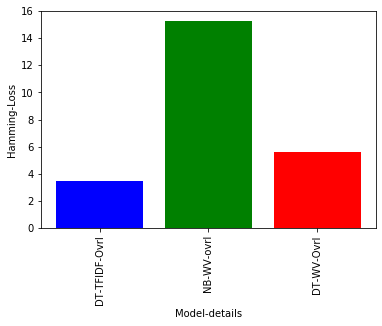

In [251]:
x = ['DT-TFIDF-Ovrl','NB-WV-ovrl','DT-WV-Ovrl']
y = [3.45,15.27,5.6]
colors = itertools.cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k'])
plt.ylabel('Hamming-Loss')
plt.xlabel('Model-details')
plt.xticks(rotation=90)
for i in range(len(y)):
    plt.bar(x[i], y[i], color=next(colors))
plt.show()

#### Summary:
The model Decision Tree with TF-IDF vectorizer is performing better than other models after applying grid search and tuning the model to max_depth as 1, with Hamming loss of 3.45.

### Model Result Submission

In [178]:
predicted1=pipe_dt_tf.predict(X_test)
label_cols=toxic_train.columns[2:8]
submid = pd.DataFrame({'id': toxic_test_label["id"]})
submission = pd.concat([submid, pd.DataFrame(predicted1, columns = label_cols)], axis=1)
submission.to_csv('submission_W2v_m1.csv', index=False)